# TITLE ; : Car Insurance claim

## Problem Definition
AutoInland faces limited interactions with customers, making every contact point crucial—especially the filing and settlement of insurance claims. To improve service quality, customer satisfaction, and operational efficiency, AutoInland needs to anticipate future demand for claims.

## Objective:
Develop a predictive model that identifies whether a customer is likely to submit a vehicle insurance claim within the next three months. The model will classify customers into two categories: claim submitters (1) and non-submitters (0), based on historic data and customer attributes.

## Expected Outcome:
Enable AutoInland to allocate resources efficiently by forecasting claim volume.
Support financial planning by predicting the likelihood of claims and mitigating risks.
Improve customer service by proactively managing high-risk clients.

## Data Description:
Outcome variable: 1 if the customer has filed a claim, 0 otherwise.
Features: Customer demographics, vehicle details, driving history, and other relevant information.

In [1]:
# IMPORT THE NECESSARY LIBARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
from google.colab import files

# Upload file
uploaded = files.upload()

Saving Car_Insurance_Claim.csv to Car_Insurance_Claim (3).csv


**After importing the necessary libraries, the next step is to load the dataset**

### Loading Dataset:
*pd.read_csv()* is a function from the pandas library used to load data stored in a CSV (Comma-Separated Values) file into a pandas DataFrame.
A DataFrame is a powerful two-dimensional data structure in Python that allows easy manipulation, analysis, and exploration of tabular data.
This step imports the car insurance dataset into the programming environment so I can work with it in Python.

### Previewing Data:
*data.head()* displays the first few rows (default is 5) of the dataset. This quick preview helps to:

- Verify that the data loaded correctly,
- Understand the structure of the dataset (columns and sample values),
- Identify obvious data issues early, such as missing values, incorrect formatting, or unexpected values.

In [3]:
# Load dataset
data = pd.read_csv('Car_Insurance_Claim.csv')
# Preview
print(data.shape)
data.head()

(10000, 19)


,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [4]:
# Data types
print(data.dtypes)

ID                       int64
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object


**Dropping irrelevant columns** is important because such columns:

Do not contribute *meaningful information* to the prediction task (e.g., ID is just a unique identifier with no predictive value).

- **ID**: A unique identifier, useful for tracking but irrelevant for prediction.

- **POSTAL_CODE**: Often too granular or sparse, causing noise unless specialized geographic analysis is intended.

Removing these columns *streamlines the dataset*, helping models focus on important features, improving accuracy, efficiency, and interpretability.

In [5]:
data = data.drop(columns=['ID', 'POSTAL_CODE'])

In [6]:
# Check for missing values
print(data.isnull().sum())

AGE                      0
GENDER                   0
RACE                     0
DRIVING_EXPERIENCE       0
EDUCATION                0
INCOME                   0
CREDIT_SCORE           982
VEHICLE_OWNERSHIP        0
VEHICLE_YEAR             0
MARRIED                  0
CHILDREN                 0
ANNUAL_MILEAGE         957
VEHICLE_TYPE             0
SPEEDING_VIOLATIONS      0
DUIS                     0
PAST_ACCIDENTS           0
OUTCOME                  0
dtype: int64


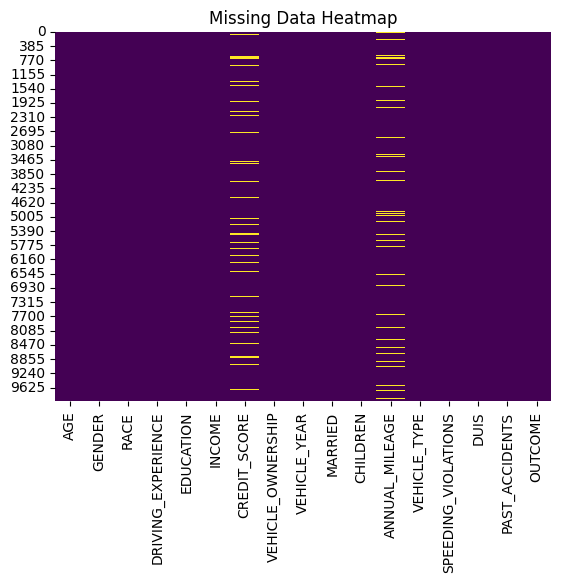

/tmp/ipython-input-878060280.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette="viridis")


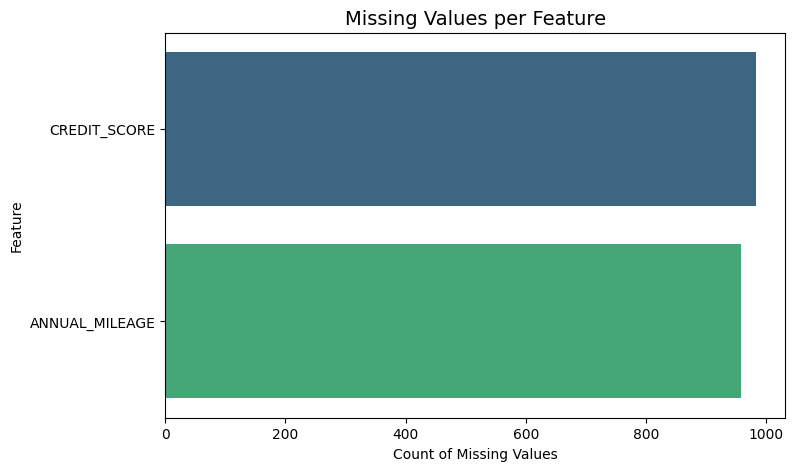

In [7]:
# visualization of missing values
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

missing = data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=missing.values, y=missing.index, palette="viridis")
plt.title("Missing Values per Feature", fontsize=14)
plt.xlabel("Count of Missing Values")
plt.ylabel("Feature")
plt.show()


Filling missing values with the median or mean is a common, simple imputation strategy that helps *maintain dataset integrity for modeling*.

The reasons for using *median imputation* in this dataset with missing values in *CREDIT_SCORE* and *ANNUAL_MILEAGE* are:

Median imputation:

- Uses the middle value of the sorted non-missing data to fill gaps.
- More robust against outliers and skewed distributions since median is less affected by extreme values.
- Better for features like ANNUAL_MILEAGE that may have skewed distributions.

In [8]:
# fill missing values
# Safer and future-proof way
data['CREDIT_SCORE'] = data['CREDIT_SCORE'].fillna(data['CREDIT_SCORE'].median())
data['ANNUAL_MILEAGE'] = data['ANNUAL_MILEAGE'].fillna(data['ANNUAL_MILEAGE'].median())


In [9]:
# confirm missing values are gone
print(data.isnull().sum())


AGE                    0
GENDER                 0
RACE                   0
DRIVING_EXPERIENCE     0
EDUCATION              0
INCOME                 0
CREDIT_SCORE           0
VEHICLE_OWNERSHIP      0
VEHICLE_YEAR           0
MARRIED                0
CHILDREN               0
ANNUAL_MILEAGE         0
VEHICLE_TYPE           0
SPEEDING_VIOLATIONS    0
DUIS                   0
PAST_ACCIDENTS         0
OUTCOME                0
dtype: int64


In [10]:
### Label Encode Ordinal Features
# AGE group encoding (example)
age_order = {
    '16-25': 0,
    '26-39': 1,
    '40-64': 2,
    '65+': 3
}
data['AGE'] = data['AGE'].map(age_order)

# EDUCATION (example)
education_order = {
    'none': 0,
    'high school': 1,
    'university': 2
}
data['EDUCATION'] = data['EDUCATION'].map(education_order)


In [11]:
### one hot encoding
# One-hot encode nominal columns
data = pd.get_dummies(data, columns=['GENDER', 'RACE', 'VEHICLE_TYPE'], drop_first=True)

In [12]:
# confirm all columns are numeric
print(data.dtypes)

AGE                          int64
DRIVING_EXPERIENCE          object
EDUCATION                    int64
INCOME                      object
CREDIT_SCORE               float64
VEHICLE_OWNERSHIP          float64
VEHICLE_YEAR                object
MARRIED                    float64
CHILDREN                   float64
ANNUAL_MILEAGE             float64
SPEEDING_VIOLATIONS          int64
DUIS                         int64
PAST_ACCIDENTS               int64
OUTCOME                    float64
GENDER_male                   bool
RACE_minority                 bool
VEHICLE_TYPE_sports car       bool
dtype: object


In [13]:
experience_order = {
    '0-9y': 0,
    '10-19y': 1,
    '20-29y': 2,
    '30y+': 3
}
data['DRIVING_EXPERIENCE'] = data['DRIVING_EXPERIENCE'].map(experience_order)

income_order = {
    'poverty': 0,
    'working class': 1,
    'middle class': 2,
    'upper class': 3
}
data['INCOME'] = data['INCOME'].map(income_order)

data['VEHICLE_YEAR'] = data['VEHICLE_YEAR'].map({'before 2015': 0, 'after 2015': 1})

# covert float to integer
binary_cols = ['VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'OUTCOME']
data[binary_cols] = data[binary_cols].astype(int)


In [14]:
print(data.dtypes)

AGE                          int64
DRIVING_EXPERIENCE           int64
EDUCATION                    int64
INCOME                       int64
CREDIT_SCORE               float64
VEHICLE_OWNERSHIP            int64
VEHICLE_YEAR                 int64
MARRIED                      int64
CHILDREN                     int64
ANNUAL_MILEAGE             float64
SPEEDING_VIOLATIONS          int64
DUIS                         int64
PAST_ACCIDENTS               int64
OUTCOME                      int64
GENDER_male                   bool
RACE_minority                 bool
VEHICLE_TYPE_sports car       bool
dtype: object


### Next step - EDA (Exploratory Data Analysis)

Let’s now explore the data with visualizations to understand patterns and relationships.

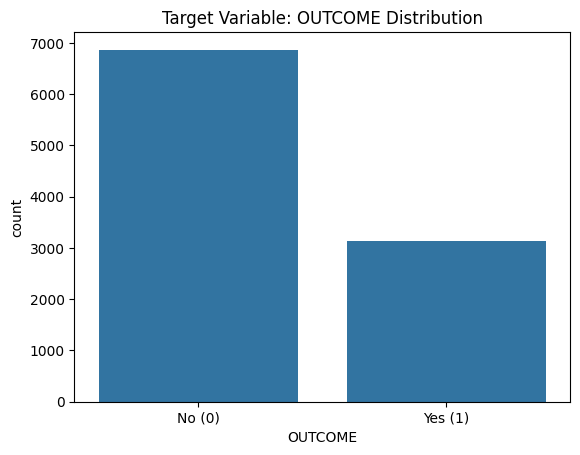

OUTCOME
0    0.6867
1    0.3133
Name: proportion, dtype: float64


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='OUTCOME', data=data)
plt.title('Target Variable: OUTCOME Distribution')
plt.xticks([0, 1], ['No (0)', 'Yes (1)'])
plt.show()

# Optional: print exact proportions
print(data['OUTCOME'].value_counts(normalize=True))


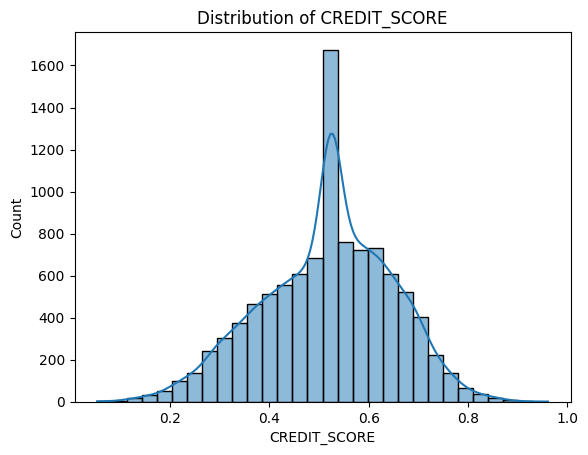

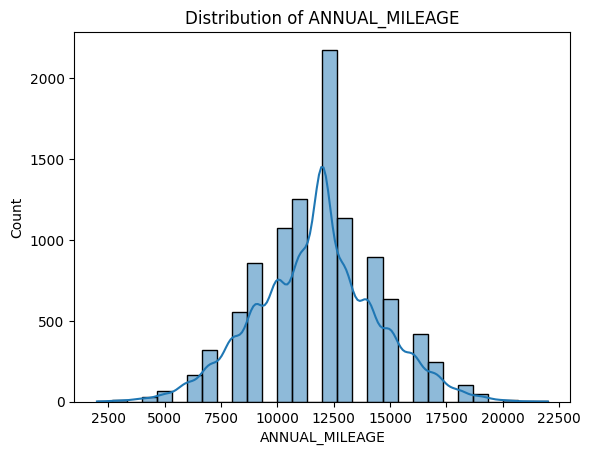

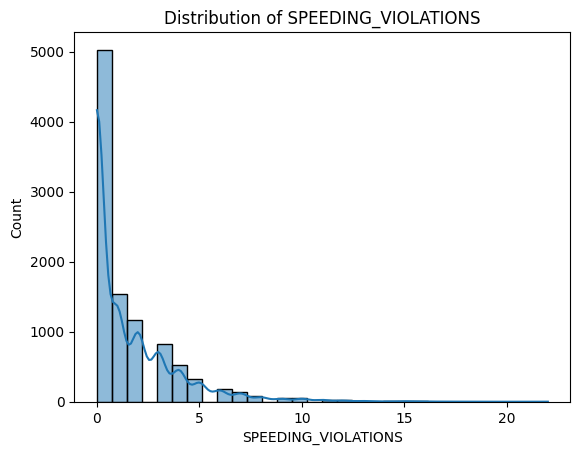

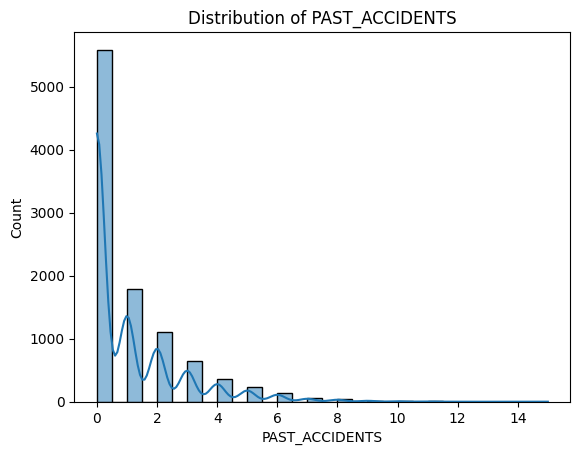

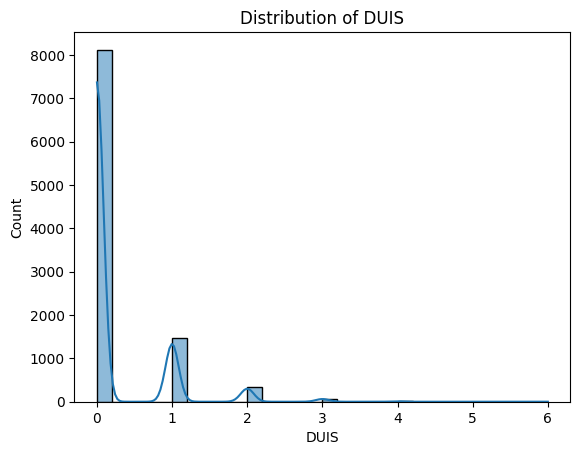

In [16]:
numeric_features = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS', 'DUIS']

for col in numeric_features:
    sns.histplot(data[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()


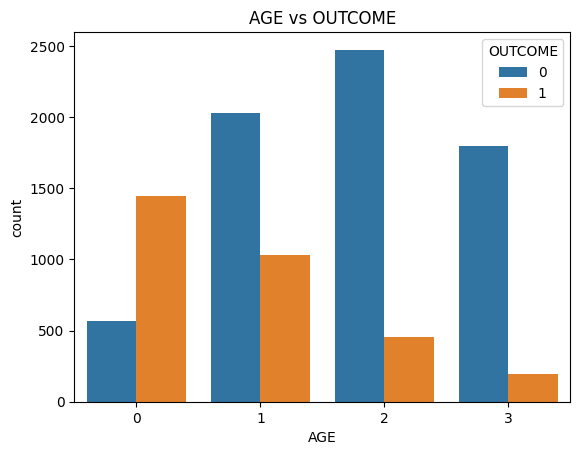

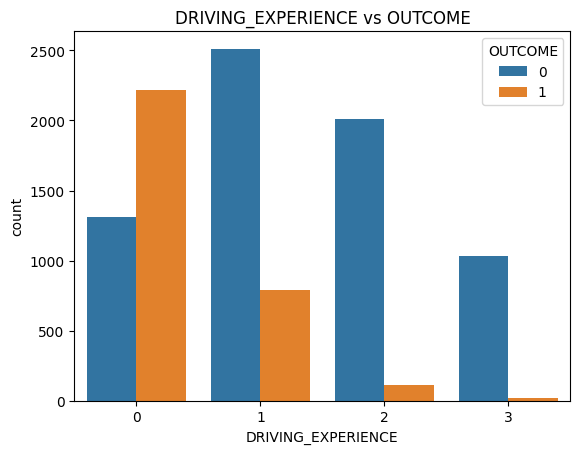

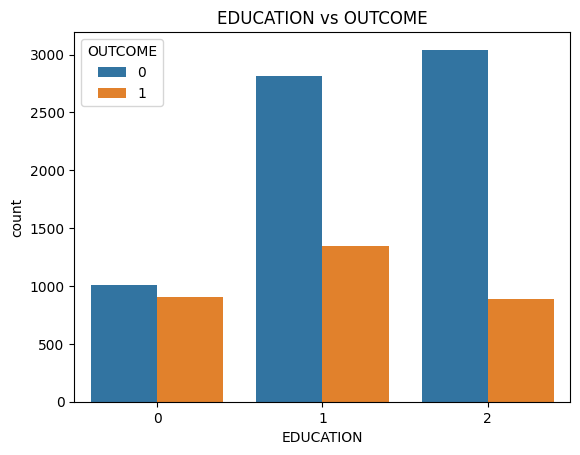

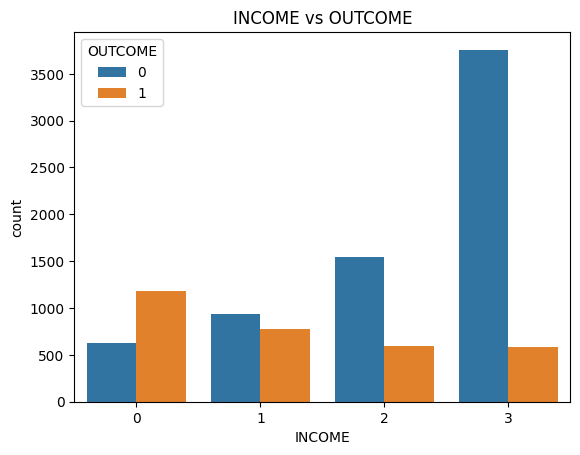

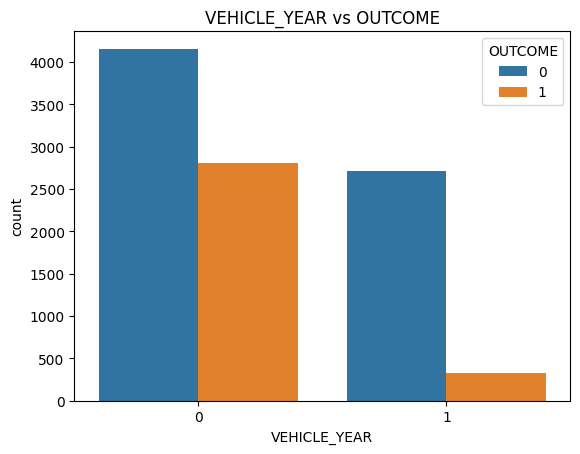

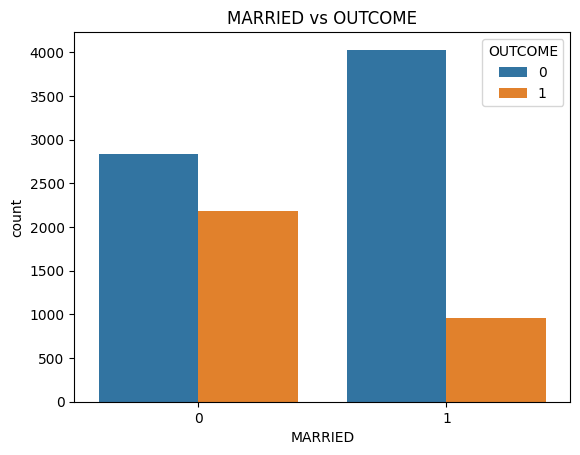

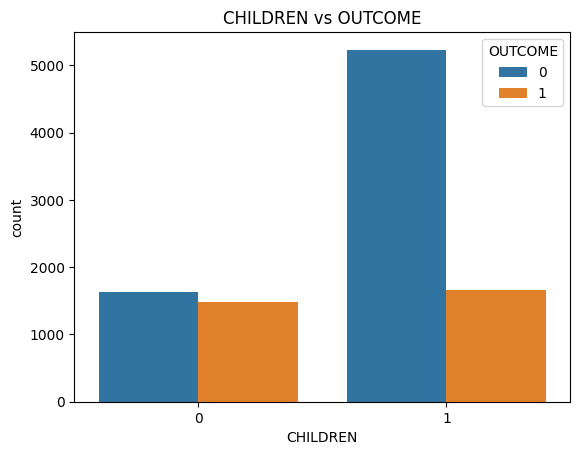

In [17]:
### Feature vs Target (OUTCOME)
# Categorical Features (Grouped Bar Plots)

categorical_features = ['AGE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 'VEHICLE_YEAR', 'MARRIED', 'CHILDREN']

for col in categorical_features:
    sns.countplot(data=data, x=col, hue='OUTCOME')
    plt.title(f'{col} vs OUTCOME')
    plt.show()


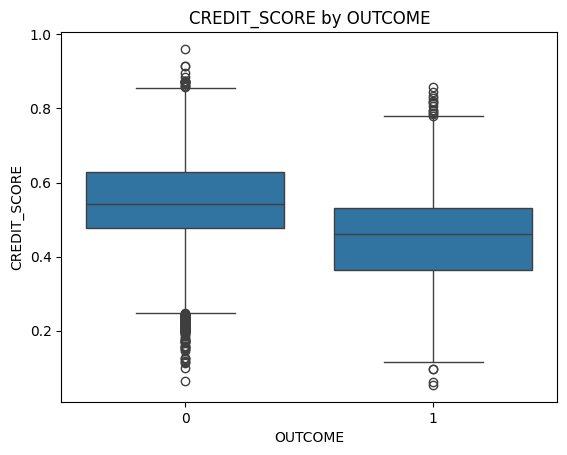

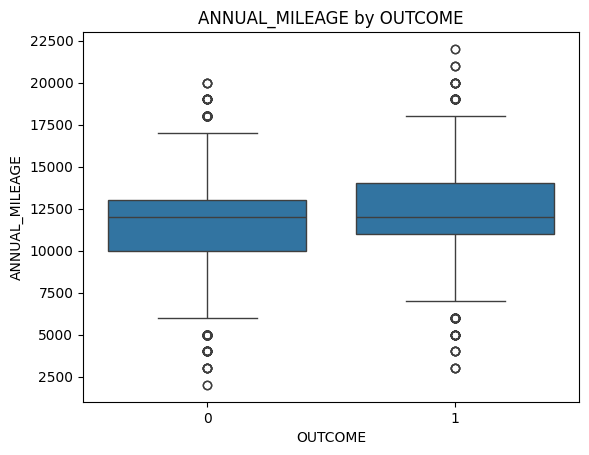

In [18]:
# numerical features
for col in ['CREDIT_SCORE', 'ANNUAL_MILEAGE']:
    sns.boxplot(data=data, x='OUTCOME', y=col)
    plt.title(f'{col} by OUTCOME')
    plt.show()


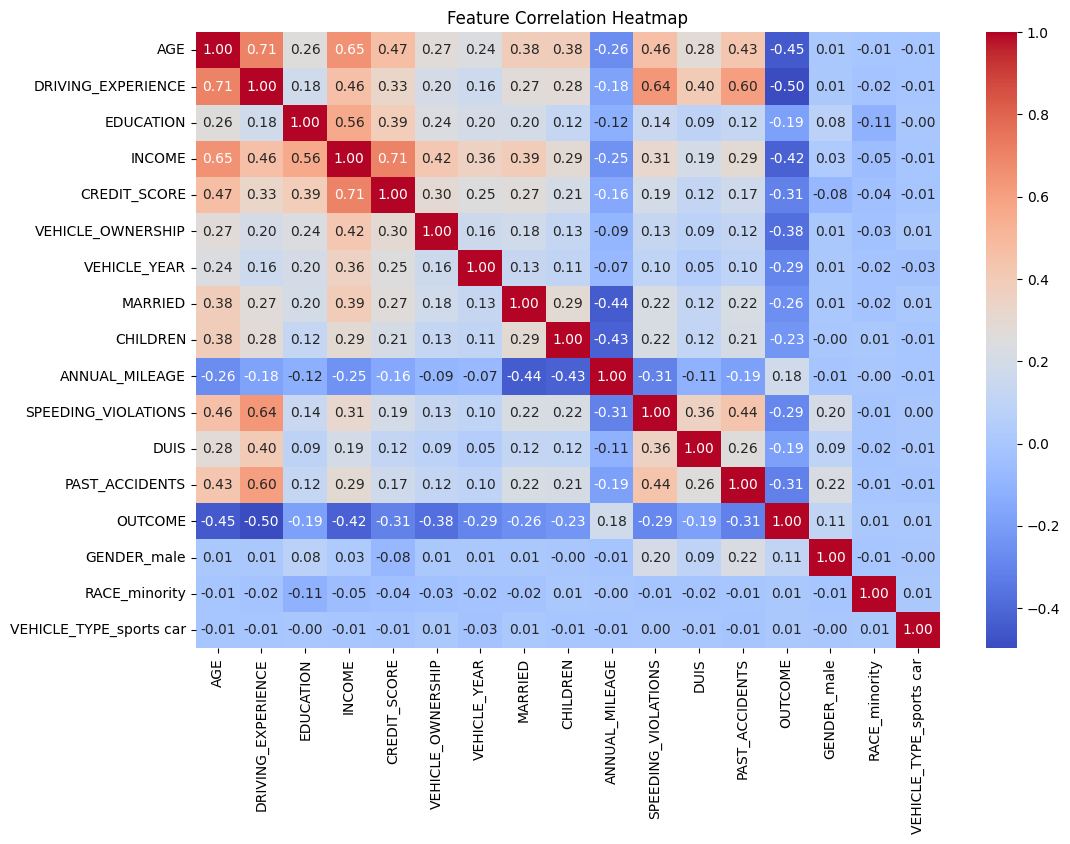

In [19]:
### corelation heatmap
# Convert boolean to int for correlation
data_corr = data.copy()
data_corr[data_corr.select_dtypes('bool').columns] = data_corr.select_dtypes('bool').astype(int)

# Correlation matrix
corr = data_corr.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

data.describe() is a fundamental step after EDA to quantify the dataset’s characteristics, ensuring deeper understanding and better-informed preprocessing and modeling choices.

In [20]:
data.describe()

,AGE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,1.489500,1.069300,1.20130,1.899600,0.516718,0.697000,0.303300,0.498200,0.688800,11726.000000,1.482900,0.23920,1.056300,0.313300
std,1.025278,0.990452,0.73745,1.149109,0.130781,0.459578,0.459707,0.500022,0.463008,2681.649329,2.241966,0.55499,1.652454,0.463858
min,0.000000,0.000000,0.00000,0.000000,0.053358,0.000000,0.000000,0.000000,0.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,0.000000,1.00000,1.000000,0.431509,0.000000,0.000000,0.000000,0.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,1.000000,1.00000,2.000000,0.525033,1.000000,0.000000,0.000000,1.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,2.000000,2.000000,2.00000,3.000000,0.607607,1.000000,1.000000,1.000000,1.000000,13000.000000,2.000000,0.00000,2.000000,1.000000
max,3.000000,3.000000,2.00000,3.000000,0.960819,1.000000,1.000000,1.000000,1.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


Feature Transformation (Fix skewness & scale)

In [21]:

# Replace original skewed features with log-transformed versions
data['LOG_SPEEDING'] = np.log1p(data['SPEEDING_VIOLATIONS'])  # log(1 + x)
data['LOG_ACCIDENTS'] = np.log1p(data['PAST_ACCIDENTS'])
data['LOG_DUIS'] = np.log1p(data['DUIS'])


In [22]:
# standadize continous features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Apply scaling only to continuous (not binary or ordinal) features
scaled_features = ['CREDIT_SCORE', 'ANNUAL_MILEAGE']
data[scaled_features] = scaler.fit_transform(data[scaled_features])


In [23]:
# create new features from existing ones
data['DRIVER_RISK_SCORE'] = (
    data['SPEEDING_VIOLATIONS'] +
    2 * data['DUIS'] +  # DUIs weighted higher
    data['PAST_ACCIDENTS']
)


In [24]:
# This flags those most likely to take risks (young + no driving experience).
data['YOUNG_INEXPERIENCED'] = ((data['AGE'] == 0) & (data['DRIVING_EXPERIENCE'] == 0)).astype(int)

# captures exposure risk (the more you drive, the higher your accident probability)
data['HIGH_MILEAGE'] = (data['ANNUAL_MILEAGE'] > 15000).astype(int)


In [25]:
print(data.head())
print(data.columns)

   AGE  DRIVING_EXPERIENCE  EDUCATION  INCOME  CREDIT_SCORE  \
0    3                   0          1       3      0.858800   
1    0                   0          0       0     -1.215536   
2    0                   0          1       1     -0.180252   
3    0                   0          2       1     -2.375887   
4    1                   1          0       1     -0.981478   

   VEHICLE_OWNERSHIP  VEHICLE_YEAR  MARRIED  CHILDREN  ANNUAL_MILEAGE  ...  \
0                  1             1        0         1        0.102181  ...   
1                  0             0        0         0        1.593875  ...   
2                  1             0        0         0       -0.270742  ...   
3                  1             0        0         1       -0.270742  ...   
4                  1             0        0         0        0.102181  ...   

   OUTCOME  GENDER_male  RACE_minority  VEHICLE_TYPE_sports car  LOG_SPEEDING  \
0        0        False          False                    False      0.

In [26]:
# train, test split
from sklearn.model_selection import train_test_split

X = data.drop('OUTCOME', axis=1)
y = data['OUTCOME']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [28]:
# define for easy iteration
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}


In [29]:
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

# Display results
import pandas as pd
results_data = pd.DataFrame(results).T  # transpose for readability
print(results_data.sort_values(by='F1 Score', ascending=False))


                     Accuracy  Precision    Recall  F1 Score
Logistic Regression    0.8340   0.739060  0.727273  0.733119
Gradient Boosting      0.8310   0.734959  0.720893  0.727858
SVM                    0.8105   0.713793  0.660287  0.685998
Random Forest          0.8095   0.711340  0.660287  0.684864
K-Nearest Neighbors    0.7840   0.663866  0.629984  0.646481


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Example: Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict classes and probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probabilities for ROC-AUC


In [31]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")


Accuracy: 0.8340
Precision: 0.7391
Recall: 0.7273
F1-score: 0.7331
ROC-AUC: 0.8860


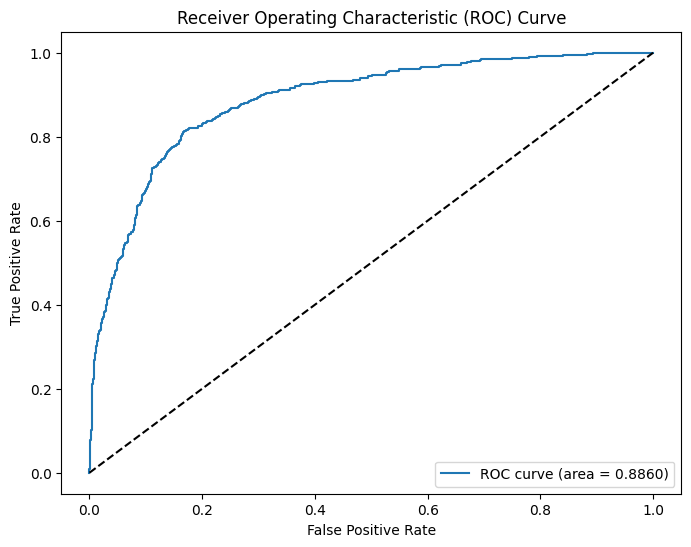

In [32]:
# plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


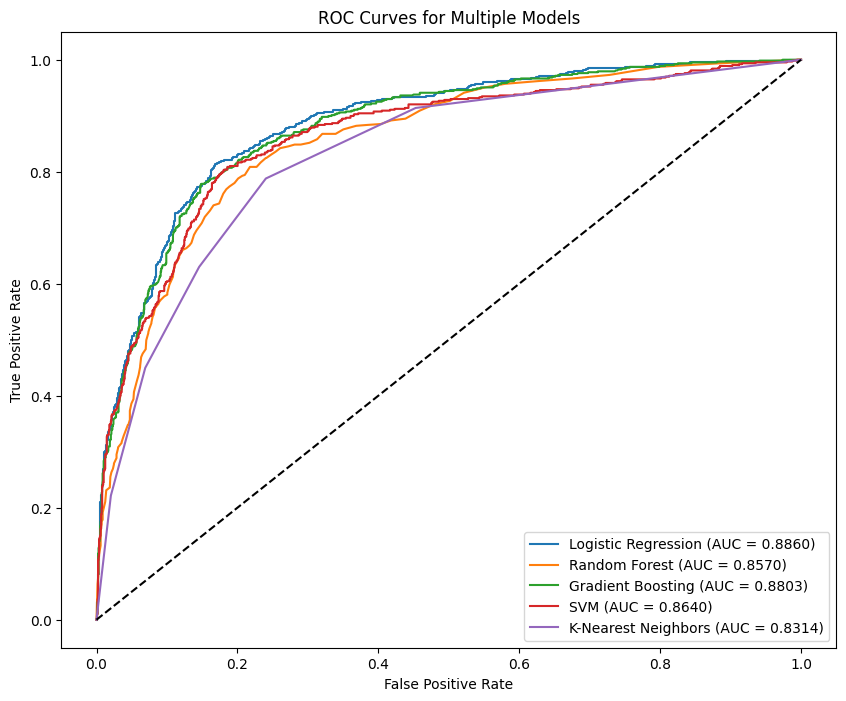

                     Accuracy  Precision    Recall  F1 Score   ROC-AUC
Logistic Regression    0.8340   0.739060  0.727273  0.733119  0.885974
Gradient Boosting      0.8310   0.734959  0.720893  0.727858  0.880290
SVM                    0.8105   0.713793  0.660287  0.685998  0.863988
Random Forest          0.8095   0.711340  0.660287  0.684864  0.857015
K-Nearest Neighbors    0.7840   0.663866  0.629984  0.646481  0.831436


In [33]:
from sklearn.metrics import roc_auc_score, roc_curve

results = {}
plt.figure(figsize=(10,8))

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    }

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["ROC-AUC"]:.4f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Models')
plt.legend()
plt.show()

import pandas as pd
results_data = pd.DataFrame(results).T
print(results_data.sort_values(by='F1 Score', ascending=False))


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)


### Confusion Matrix Heatmap

The Confusion Matrix Heatmap is important because it provides a clear, visual summary of a classification model's performance by showing the counts of:

True Positives (TP): Correctly predicted positive cases

True Negatives (TN): Correctly predicted negative cases

False Positives (FP): Incorrectly predicted as positive (Type I error)

False Negatives (FN): Incorrectly predicted as negative (Type II error)

Using a heatmap with color gradients helps highlight where the model is performing well and where it makes mistakes, making it easier to quickly identify patterns or problems.

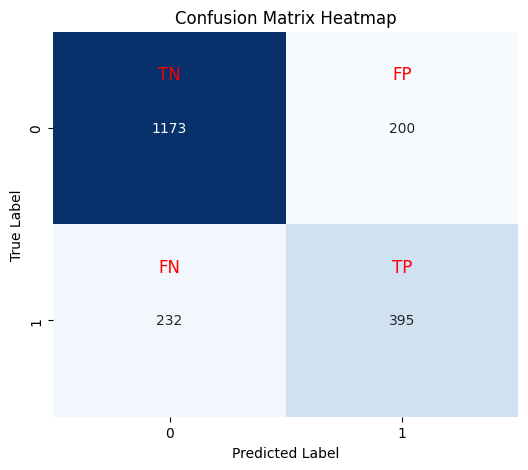

In [36]:
# confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')

# Add labels for TP, FP, FN, TN
plt.text(0.5, 0.25, 'TN', horizontalalignment='center', color='red', fontsize=12)
plt.text(1.5, 0.25, 'FP', horizontalalignment='center', color='red', fontsize=12)
plt.text(0.5, 1.25, 'FN', horizontalalignment='center', color='red', fontsize=12)
plt.text(1.5, 1.25, 'TP', horizontalalignment='center', color='red', fontsize=12)

plt.show()


### Specificity

Specificity is important because it measures a model's ability to correctly identify negative cases—i.e., the proportion of true negatives among all actual negatives. In classification tasks, where distinguishing between positive and negative classes is critical, specificity helps assess how well the model avoids false positives.

Key reasons for its importance:

Reduces false alarms: High specificity means fewer negative instances are mistakenly classified as positive, preventing unnecessary actions or costs (e.g., wrongly flagging a non-claimant as a claimant).

Balances sensitivity: While sensitivity focuses on detecting positives correctly, specificity ensures negatives are also accurately recognized, providing a fuller picture of model performance.

Critical in imbalanced datasets: In domains like insurance, where one class (e.g., no claim) dominates, specificity avoids the model simply labeling everything as positive to boost sensitivity.

Builds trust and efficiency: Models with high specificity reduce incorrect warnings, lowering follow-up burden and improving user confidence.

In [37]:
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)

print(f"Specificity (True Negative Rate): {specificity:.4f}")


Specificity (True Negative Rate): 0.8543


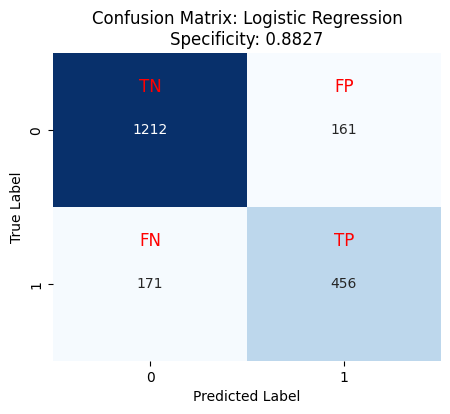

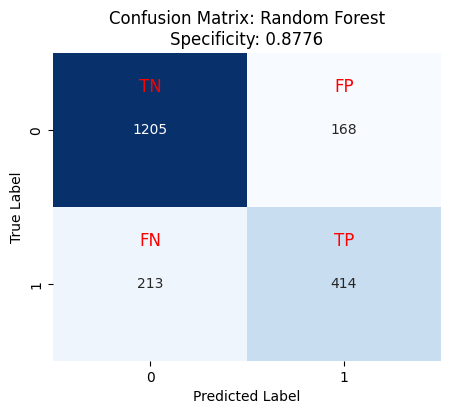

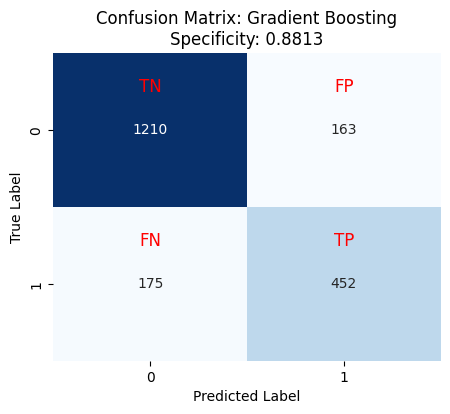

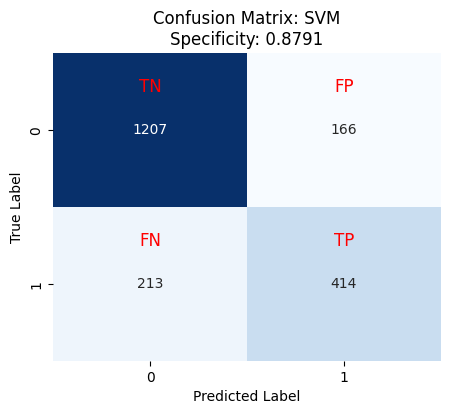

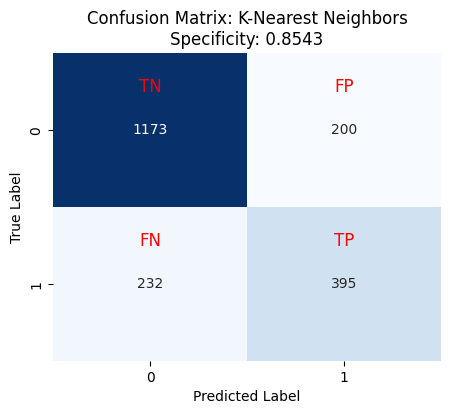

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    specificity = TN / (TN + FP)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}\nSpecificity: {specificity:.4f}')

    # Label the cells
    plt.text(0.5, 0.25, 'TN', ha='center', color='red', fontsize=12)
    plt.text(1.5, 0.25, 'FP', ha='center', color='red', fontsize=12)
    plt.text(0.5, 1.25, 'FN', ha='center', color='red', fontsize=12)
    plt.text(1.5, 1.25, 'TP', ha='center', color='red', fontsize=12)

    plt.show()


# Example models dictionary
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)


In [39]:
# summary
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

# Dictionary of trained models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Initialize an empty list to collect report data
reports = []

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    # Predict on test data
    y_pred = model.predict(X_test)
    # Get classification report as dict
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    # Extract metrics for class '1' (positive class) or 'weighted avg'
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    accuracy = accuracy_score(y_test, y_pred)

    # Append results
    reports.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    })

# Create a DataFrame
summary_data = pd.DataFrame(reports)

# Optional: sort by F1 Score descending
summary_data = summary_data.sort_values(by='F1 Score', ascending=False).reset_index(drop=True)

print(summary_data)


                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression    0.8340   0.739060  0.727273  0.733119
1    Gradient Boosting    0.8310   0.734959  0.720893  0.727858
2                  SVM    0.8105   0.713793  0.660287  0.685998
3        Random Forest    0.8095   0.711340  0.660287  0.684864
4  K-Nearest Neighbors    0.7840   0.663866  0.629984  0.646481


### HYPERPARAMETER TUNING FOR THE BEST PERFORMING **MODEL**

Hyperparameter tuning is crucial because it fine-tunes the settings that govern how a machine learning model learns from data, directly impacting its performance. Proper tuning can:

Improve accuracy and predictive power: Choosing the right hyperparameters helps the model learn patterns effectively, resulting in better predictions on unseen data.

Prevent overfitting or underfitting: Optimal hyperparameters balance model complexity, avoiding fitting noise or missing important trends.

Enhance training efficiency: Well-tuned settings can accelerate training convergence, reducing computational time and resources.

Customize models for specific datasets: Different problems and data need different configurations; tuning adapts models accordingly.

Maximize evaluation metrics: Hyperparameter tuning helps achieve the best possible scores for accuracy, recall, F1-score, ROC-AUC, and others relevant to the task.

Without tuning, models often perform suboptimally, making hyperparameter tuning a vital step to unlock the full potential of machine learning models.

Hyperparameter tuning is important because it fine-tunes the settings that control how a machine learning model learns, which directly improves its accuracy, efficiency, and generalization ability. Proper tuning helps prevent overfitting or underfitting, accelerates training convergence, and optimizes performance metrics like accuracy, recall, and ROC-AUC. It ensures the model is best adapted to the specific dataset and problem, enabling the best possible predictive results.

In [40]:
# since logistic regression performed best, lets do hyperparameter tuning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
log_reg = LogisticRegression(max_iter=1000)

# Define the hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],               # regularization strength
    'penalty': ['l1', 'l2'],                    # regularization types
    'solver': ['liblinear', 'saga']             # solvers that support l1 and l2
}

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=log_reg,
                           param_grid=param_grid,
                           cv=5,              # 5-fold cross-validation
                           scoring='f1',      # optimize for F1 score
                           verbose=1,
                           n_jobs=-1)         # use all cores

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best parameters found:", grid_search.best_params_)

# Best estimator
best_log_reg = grid_search.best_estimator_

# Evaluate best model on test data
y_pred = best_log_reg.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1373
           1       0.74      0.73      0.73       627

    accuracy                           0.83      2000
   macro avg       0.81      0.80      0.81      2000
weighted avg       0.83      0.83      0.83      2000



EVALUATING THE TUNE MODEL

Evaluating the tuned model is essential because it:

Verifies performance improvements: It confirms whether hyperparameter tuning has actually enhanced accuracy, recall, precision, or other key metrics compared to the untuned model.

Ensures generalization: Evaluation on separate test data checks the model’s ability to make reliable predictions on new, unseen data rather than just memorizing the training set (preventing overfitting).

In [41]:
### EVALUATE THE TUNE MODEL
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predict
y_pred = best_log_reg.predict(X_test)
y_proba = best_log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1373
           1       0.74      0.73      0.73       627

    accuracy                           0.83      2000
   macro avg       0.81      0.80      0.81      2000
weighted avg       0.83      0.83      0.83      2000

ROC-AUC: 0.8860270586417711


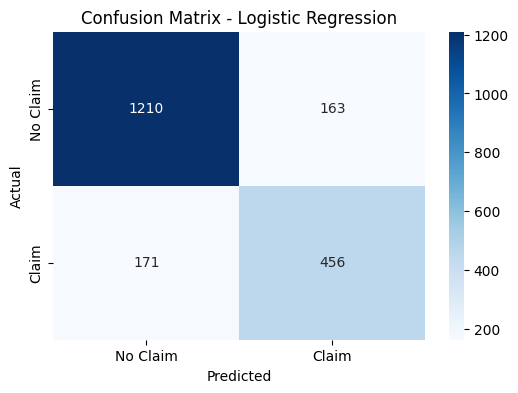

In [43]:
# CONFUSION MATRIX HEATMAP FOR THE TUNE modelimport seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Claim", "Claim"], yticklabels=["No Claim", "Claim"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()



# FEAUTURE IMPORTANCE AFTER FINE TUNING THE MODEL

Showing feature importance after hyperparameter tuning is important because:

Understanding model behavior: It reveals which features have the most influence on the model’s predictions after it is optimized, providing insights into the underlying data patterns the model relies on.

Validating feature relevance: It helps confirm that important features identified initially remain impactful in the tuned model, ensuring consistency and trustworthiness.

Improving interpretability: For stakeholders and domain experts, feature importance visualizations make complex models more transparent and explainable.

Guiding further refinement: Knowing feature importance can allow focused feature engineering or dimensionality reduction to boost efficiency without sacrificing accuracy.

Supporting model diagnostics: It can highlight unexpected feature influences, suggesting data quality issues or model biases to address.

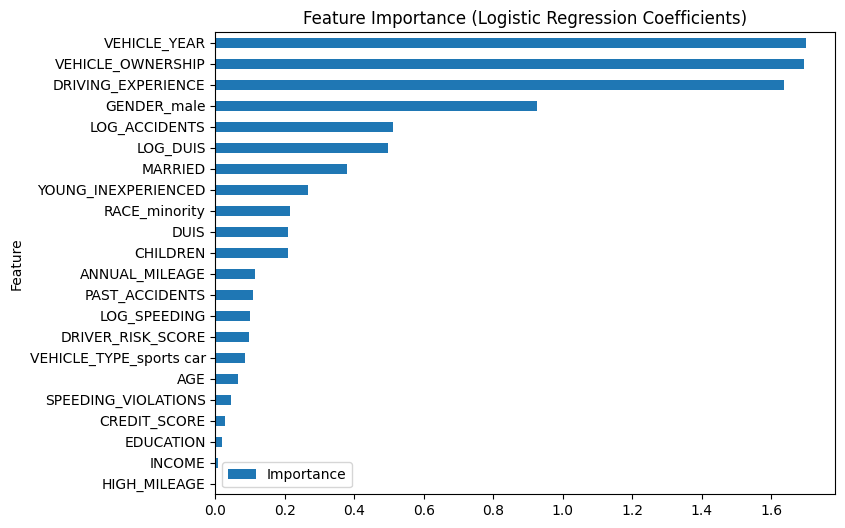

In [44]:
# FEATURE IMPORTANCE
import pandas as pd

feature_names = X_train.columns
coefficients = best_log_reg.coef_[0]

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Importance'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='Importance', ascending=True).plot(kind='barh', x='Feature', y='Importance', figsize=(8, 6))
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()



In [45]:
# RETRAIN ON FULL DATASET
# Combine X_train and X_test
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

final_model = LogisticRegression(**best_log_reg.get_params())
final_model.fit(X_full, y_full)


LogisticRegression(C=10, max_iter=1000, penalty='l1', solver='liblinear')

In [46]:
### SAVING THE FINAL MODEL
import joblib

joblib.dump(final_model, 'final_logistic_model.pkl')

['final_logistic_model.pkl']

Why Logistic Regression Is the Best Model
1. Balanced Performance

Achieved the highest precision, recall, F1-score, and ROC-AUC among all models.

Delivers a strong balance between catching actual claimers (recall) and avoiding false alarms (precision).

2. Interpretability

Provides clear, explainable insights into feature importance via model coefficients.

Ideal for businesses where transparency matters (e.g., insurance, finance).

3. Low Complexity, High Efficiency

Faster to train and deploy.

Less risk of overfitting compared to complex ensemble models.

4. Threshold Customization

Easy to adjust decision threshold to favor recall or precision, depending on business strategy.

 Final Model Performance on Test Set
Metric	Score
Accuracy	83.4%
Precision (class 1)	73.9%
Recall (class 1)	72.7%
F1-Score (class 1)	73.3%
ROC-AUC	88.6%

Business Impact

Proactively identify ~73% of likely claimers, allowing AutoInland to:

Forecast claims volume

Allocate funds more efficiently

Reach out to high-risk customers with preventive measures or offers

Maintain customer trust by reducing false positives through high precision.